<header> Mimic III v1.4 Investigation </header> 

### Part 1: Import the data

All data has been downloaded from the Mimic-III website:

MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available from: http://www.nature.com/articles/sdata201635

Access can be granted via PhysioNetWorks:

Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220 [Circulation Electronic Pages; http://circ.ahajournals.org/content/101/23/e215.full]; 2000 (June 13).

First we need to import the needed modules.  Let us test psycopg2 which will allow us to access our PSQL database using Python.

In [1]:
#Import necessary modules

import psycopg2
import psycopg2.extras
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score
import mimic_visuals as vs


#Connect to PSQL database
try:
    conn = psycopg2.connect(dbname="mimic", user="postgres", password="password")
except:
    print "I am unable to connect to the database"

#Create cursor to access tables from database    
curr = conn.cursor()
try:
    curr.execute("SELECT LOS from ICUSTAYS")
except:
    print "I cannot SELECT from ADMISSIONS"

#Fetch all rows from table    
rows = curr.fetchall()
print rows[1]
rowcount = curr.rowcount
print "Length is ", rowcount
print "\nRows: \n"

#Example creating groups of patients based on length of stay (LOS)
none_count =0
los_sum = 0.
los_groups = {"<1 day": 0, "1-2 days": 0, "2-3 days": 0, "3-5 days": 0, "5-10 days":0, "10+ days": 0}
for record in rows:
    if record[0] is not None:
        los_sum = los_sum + record[0]
        if record[0] <= 1.0:
            los_groups["<1 day"] = los_groups["<1 day"]+1
        elif record[0]<=2.0:
            los_groups["1-2 days"] = los_groups["1-2 days"]+1
        elif record[0]<=3.0:
            los_groups["2-3 days"] = los_groups["2-3 days"]+1
        elif record[0]<=5.0:
            los_groups["3-5 days"] = los_groups["3-5 days"]+1
        elif record[0]<=10.0:
            los_groups["5-10 days"] = los_groups["5-10 days"]+1
        else:
            los_groups["10+ days"] = los_groups["10+ days"]+1
        
    else:
        none_count += 1
        
        
los_average = los_sum/(rowcount-none_count)
print "Number of rows with no LOS data", none_count
print "Average Length of Stay is ", los_average
print los_groups

#Close cursor after finished accessing table
curr.close()

(3.2788,)
Length is  61532

Rows: 

Number of rows with no LOS data 10
Average Length of Stay is  4.9179715809
{'10+ days': 6771, '2-3 days': 9644, '<1 day': 12311, '3-5 days': 8801, '1-2 days': 16901, '5-10 days': 7094}


In [2]:
#Access relevant fields from ADMISSIONS table
curr2 = conn.cursor()
try:
    curr2.execute("SELECT SUBJECT_ID, HADM_ID, ADMITTIME, DISCHTIME, DEATHTIME,INSURANCE, LANGUAGE,"
                  "RELIGION, MARITAL_STATUS, ETHNICITY from ADMISSIONS")
except:
    print "I cannot SELECT from ADMISSIONS"

#Get column names for Pandas DataFrame
admcolnames = [desc[0] for desc in curr2.description]    
#Create Pandas DataFrame
dfadm = pd.DataFrame(curr2.fetchall(), columns=admcolnames)
print dfadm.head() #Get data sample
print len(dfadm.index)
curr2.close()

   subject_id  hadm_id           admittime           dischtime deathtime  \
0          22   165315 2196-04-09 12:26:00 2196-04-10 15:54:00      None   
1          23   152223 2153-09-03 07:15:00 2153-09-08 19:10:00      None   
2          23   124321 2157-10-18 19:34:00 2157-10-25 14:00:00      None   
3          24   161859 2139-06-06 16:14:00 2139-06-09 12:48:00      None   
4          25   129635 2160-11-02 02:06:00 2160-11-05 14:55:00      None   

  insurance language           religion marital_status ethnicity  
0   Private     None       UNOBTAINABLE        MARRIED     WHITE  
1  Medicare     None           CATHOLIC        MARRIED     WHITE  
2  Medicare     ENGL           CATHOLIC        MARRIED     WHITE  
3   Private     None  PROTESTANT QUAKER         SINGLE     WHITE  
4   Private     None       UNOBTAINABLE        MARRIED     WHITE  
58976


In [3]:
#Access relevant fields from PATIENTS table
curr3 = conn.cursor()
try:
    curr3.execute("SELECT SUBJECT_ID, GENDER, DOB, DOD, EXPIRE_FLAG from PATIENTS")
except:
    print "I cannot SELECT from PATIENTS"

#Create PATIENTS DataFrame
patcolnames = [desc[0] for desc in curr3.description]
dfpat = pd.DataFrame(curr3.fetchall(), columns=patcolnames)
print dfpat.head()
print len(dfpat.index)
curr3.close()
#print dfpat['expire_flag'].value_counts(dropna = False)

   subject_id gender        dob        dod  expire_flag
0         249      F 2075-03-13        NaT            0
1         250      F 2164-12-27 2188-11-22            1
2         251      M 2090-03-15        NaT            0
3         252      M 2078-03-06        NaT            0
4         253      F 2089-11-26        NaT            0
46520


#### Merge the imported data

In [4]:
#Merge ADMISSIONS and PATIENTS table
dfadmpat = dfpat.merge(dfadm, how='inner', on="subject_id")
print dfadmpat.head(n=5)
print len(dfadmpat.index)
#print dfadmpat['expire_flag'].value_counts(dropna = False)
#dfadmpat.drop_duplicates('subject_id', keep='last', inplace=True)
#print dfadmpat['expire_flag'].value_counts(dropna = False)

   subject_id gender        dob        dod  expire_flag  hadm_id  \
0         249      F 2075-03-13        NaT            0   116935   
1         249      F 2075-03-13        NaT            0   149546   
2         249      F 2075-03-13        NaT            0   158975   
3         250      F 2164-12-27 2188-11-22            1   124271   
4         251      M 2090-03-15        NaT            0   117937   

            admittime           dischtime            deathtime insurance  \
0 2149-12-17 20:41:00 2149-12-31 14:55:00                 None  Medicare   
1 2155-02-03 20:16:00 2155-02-14 11:15:00                 None  Medicare   
2 2156-04-27 15:33:00 2156-05-14 15:30:00                 None  Medicare   
3 2188-11-12 09:22:00 2188-11-22 12:00:00  2188-11-22 12:00:00  Self Pay   
4 2110-07-27 06:46:00 2110-07-29 15:23:00                 None   Private   

  language       religion marital_status               ethnicity  
0     None       CATHOLIC       DIVORCED                   WHITE  


In [5]:
from IPython.display import display

#Access relevant fields from ICUSTAYS table
curr4 = conn.cursor()
try:
    curr4.execute("SELECT SUBJECT_ID, HADM_ID, LOS from ICUSTAYS")
except:
    print "I cannot SELECT from ICUSTAYS"

#Create ICUSTAYS DataFrame    
icucolnames = [desc[0] for desc in curr4.description]
dficu = pd.DataFrame(curr4.fetchall(), columns=icucolnames)
print len(dficu.index)
print dficu.head()

dficu['los_scaled'] = np.log(dficu.los)

print max(dficu['los'])
print max(dficu['los_scaled'])

#Look for scaled LOS outliers
Q1 = np.nanpercentile(dficu['los_scaled'], 25)
print 'Q1 is', Q1
    
Q3 = np.nanpercentile(dficu['los_scaled'], 75)
print 'Q3 is', Q3

step = 5.0 * (Q3-Q1)
print "Data points considered outliers for the feature '{}':".format('los_scaled')
display(dficu['los_scaled'][~((dficu['los_scaled'] >= Q1 - step) & (dficu['los_scaled'] <= Q3 + step))])

#Merge 
dfmimic = dfadmpat.merge(dficu, how="inner", on=['hadm_id', 'subject_id'])
print len(dfmimic.index)
print dfmimic['expire_flag'].value_counts(dropna = False)
#Drop duplicate data, it can be assumed if there are multiple admissions
#of the same patient, they will have survived the earlier admissions.
dfmimic.drop_duplicates('hadm_id', inplace=True) #Drop duplicate hospital admission data
print len(dfmimic.index)
print dfmimic['expire_flag'].value_counts(dropna = False)
dfmimic.drop_duplicates('subject_id', keep='last', inplace=True) #Drop duplicate subject data
print len(dfmimic.index)
print dfmimic['expire_flag'].value_counts(dropna = False)

#Name the final DataFrame
dfmimic.name = 'dfmimic'

curr4.close()

61532
   subject_id  hadm_id     los
0         268   110404  3.2490
1         269   106296  3.2788
2         270   188028  2.8939
3         271   173727  2.0600
4         272   164716  1.6202
173.0725
5.15371058185
Q1 is 0.102579150484
Q3 is 1.50033150072
Data points considered outliers for the feature 'los_scaled':


1033          NaN
5918    -8.111728
6451          NaN
10165         NaN
10507         NaN
10771   -8.111728
13080         NaN
13346   -9.210340
15156         NaN
17759         NaN
18442         NaN
24081   -8.517193
24781   -6.907755
27840         NaN
28121   -7.130899
29117         NaN
33110   -7.418581
45725   -7.824046
48101   -7.824046
Name: los_scaled, dtype: float64

61532
0    37341
1    24191
Name: expire_flag, dtype: int64
57786
0    35744
1    22042
Name: expire_flag, dtype: int64
46476
0    30739
1    15737
Name: expire_flag, dtype: int64


Let's get counts by gender ('M' or 'F') and whether they lived or died.

In [6]:
print len(dfmimic.index)

#Group by gender
mimic_by_gender = dfmimic.groupby('gender') #DataFrame grouped by gender
print mimic_by_gender.head()
print mimic_by_gender['expire_flag'].sum() #Sum of deaths
print mimic_by_gender['expire_flag'].value_counts() #Counts of deaths vs no deaths by gender
print dfmimic['expire_flag'].sum()
print dfmimic['expire_flag'].value_counts(dropna = False)

46476
    subject_id gender        dob        dod  expire_flag  hadm_id  \
3          249      F 2075-03-13        NaT            0   158975   
5          250      F 2164-12-27 2188-11-22            1   124271   
6          251      M 2090-03-15        NaT            0   117937   
8          252      M 2078-03-06        NaT            0   193470   
9          253      F 2089-11-26        NaT            0   176189   
10         255      M 2109-08-05        NaT            0   112013   
14         256      M 2086-07-31        NaT            0   108811   
16         257      F 2031-04-03 2121-07-08            1   179006   
17         258      F 2124-09-19        NaT            0   189406   
20         261      M 2025-08-04 2102-06-29            1   118523   

             admittime           dischtime            deathtime insurance  \
3  2156-04-27 15:33:00 2156-05-14 15:30:00                 None  Medicare   
5  2188-11-12 09:22:00 2188-11-22 12:00:00  2188-11-22 12:00:00  Self Pay   
6  

We can see that our table contains data for 30739 patients that survived their stay in the ICU and 15737 patients who died in the ICU.
Let's create a benchmark model for the data that will guess all patients survived.  We will use scikit-learn's AUC function to compute the area under the curve.  

In [7]:
#Create NumPy array predicted all '1's for patient survival
mimic_length = len(dfmimic.index)
y_scores = np.ones(mimic_length, dtype=np.int)
y_true = dfmimic['expire_flag']
print roc_auc_score(y_true, y_scores)
print roc_auc_score(y_true, y_true)

0.5
1.0


Now we can find the patient's age on admission by subtracting the patient's date of birth ('dob') from the hospital's admission date ('admittime').  Patient's will be grouped by aging similarly to how the CDC grouped patient's in the National Hospital Discharge Survey 2000-2010: https://www.cdc.gov/nchs/data/databriefs/db118.htm#x2013;2010%3C/a%3E%20

In [8]:
from datetime import timedelta

def groupage(admittime, dob):
    '''
    inputs:
        -admittime: A datetime value of when the patient was admitted to the ICU
        -dob: A datetime value of the patient's Date of Birth
    output:
        The group a patient belongs to based on the difference between admittime and dob
    '''
    age_in_years = (admittime-dob)
    #Group ages based on CDC grouping
    if age_in_years >= timedelta(85*365.242):
        return '85 years and over'
    elif age_in_years >= timedelta(75*365.242):
        return '75-84 years'
    elif age_in_years >= timedelta(65*365.242):
        return '65-74 years'
    elif age_in_years >= timedelta(45*365.242):
        return '45-64 years'
    else:
        return 'Under 45 years'
    

dfmimic['age'] = dfmimic.apply(lambda row: groupage(row['admittime'], row['dob']), axis=1)
print dfmimic['age'].value_counts()
print dfmimic.head()    
    
    

Under 45 years       13620
45-64 years          12833
75-84 years           8080
65-74 years           7678
85 years and over     4265
Name: age, dtype: int64
   subject_id gender        dob        dod  expire_flag  hadm_id  \
3         249      F 2075-03-13        NaT            0   158975   
5         250      F 2164-12-27 2188-11-22            1   124271   
6         251      M 2090-03-15        NaT            0   117937   
8         252      M 2078-03-06        NaT            0   193470   
9         253      F 2089-11-26        NaT            0   176189   

            admittime           dischtime            deathtime insurance  \
3 2156-04-27 15:33:00 2156-05-14 15:30:00                 None  Medicare   
5 2188-11-12 09:22:00 2188-11-22 12:00:00  2188-11-22 12:00:00  Self Pay   
6 2110-07-27 06:46:00 2110-07-29 15:23:00                 None   Private   
8 2133-08-15 04:23:00 2133-08-19 17:30:00                 None   Private   
9 2174-01-21 20:58:00 2174-01-26 16:15:00           

Just as patient's were grouped into different age groups, patients will now be grouped by length of ICU stay based the CDC's National Hospital Discharge Survey 2000-2010: https://www.cdc.gov/nchs/data/databriefs/db118.htm#x2013;2010%3C/a%3E%20

In [9]:
def grouplos(los):
    '''
    inputs:
        -los: patient length of stay in ICU
    outputs: 
        Group based on patient length of stay
    '''
    if los >= 10:
        return '10 or more days'
    elif los >= 8:
        return '8-9 days'
    elif los >= 6:
        return '6-7 days'
    elif los >= 4:
        return '4-5 days'
    elif los >= 2:
        return '2-3 days'
    else:
        return '1 day'

dfmimic['los'] = dfmimic.apply(lambda row: grouplos(row['los']), axis=1)
print dfmimic['los'].value_counts()
    

1 day              23078
2-3 days           10733
10 or more days     5171
4-5 days            4039
6-7 days            2127
8-9 days            1328
Name: los, dtype: int64


Now let us create a dataframe with the feature we will want to train our model on

In [10]:
dffeatures = dfmimic[['gender', 'ethnicity', 'marital_status', 'insurance', 'language', 'religion', 'expire_flag', 'los', 'age']]
expire = dfmimic['expire_flag']
print dffeatures.head()

  gender               ethnicity marital_status insurance language  \
3      F                   WHITE       DIVORCED  Medicare     ENGL   
5      F  BLACK/AFRICAN AMERICAN         SINGLE  Self Pay     HAIT   
6      M   UNKNOWN/NOT SPECIFIED           None   Private     None   
8      M                   WHITE         SINGLE   Private     None   
9      F                   WHITE        WIDOWED  Medicare     None   

        religion  expire_flag              los             age  
3       CATHOLIC            0         2-3 days     75-84 years  
5  NOT SPECIFIED            1  10 or more days  Under 45 years  
6          OTHER            0            1 day  Under 45 years  
8   UNOBTAINABLE            0         2-3 days     45-64 years  
9       CATHOLIC            0            1 day     75-84 years  


#### Visualizing the data

Visualize the expiration counts based on the features

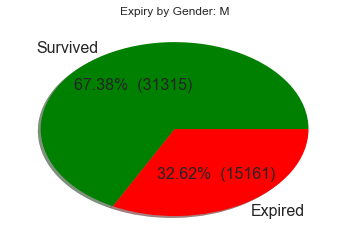

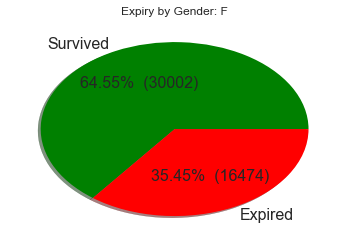

In [11]:
# Display inline matplotlib plots with IPython
%matplotlib inline
#Visualize the overall patient survival percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

gender_groups = dfmimic.groupby('gender')
for group in gender_groups.groups:
    ax = gender_groups.get_group(group)['expire_flag'].value_counts().plot(labels = ['Survived', 'Expired'], 
        autopct= make_autopct(gender_groups['expire_flag'].value_counts()), 
        shadow = True, fontsize = 16,
        kind = 'pie', colors = ['g', 'r'],
        title = 'Expiry by Gender: ' + group)
    ax.set_ylabel('')
    plt.savefig(group+'.png')
    plt.show(ax)

65-74 years


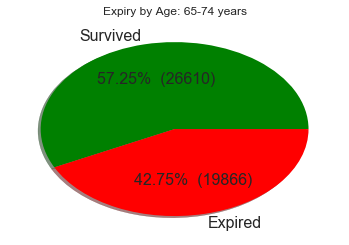

45-64 years


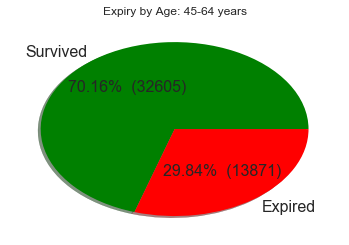

75-84 years


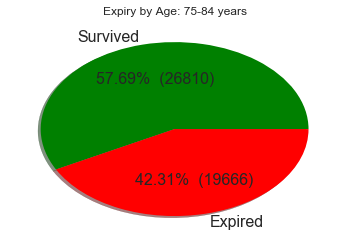

85 years and over


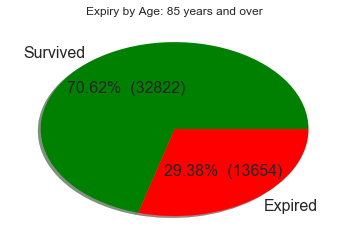

Under 45 years


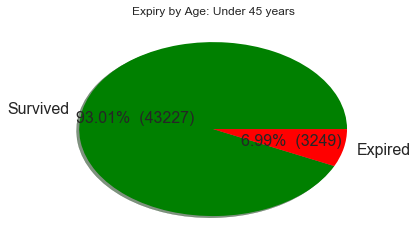

In [12]:
age_groups = dfmimic.groupby('age')
for group in age_groups.groups:
    print group
    ax = age_groups.get_group(group)['expire_flag'].value_counts().plot(labels = ['Survived', 'Expired'], 
        autopct=make_autopct(age_groups['expire_flag'].value_counts()), 
        shadow = True, fontsize = 16,
        kind = 'pie', colors = ['g', 'r'],
        title = 'Expiry by Age: ' + group)
    ax.set_ylabel('')
    plt.savefig(group+'.png')
    plt.show(ax)

10 or more days


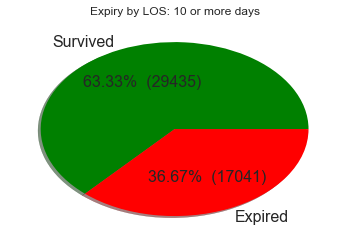

2-3 days


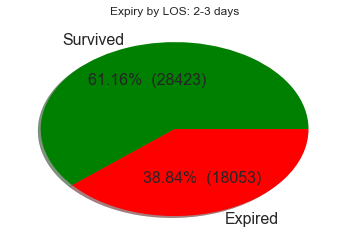

4-5 days


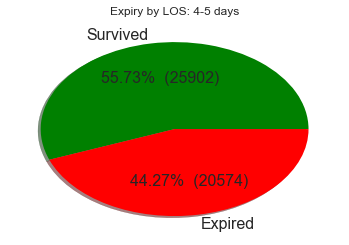

6-7 days


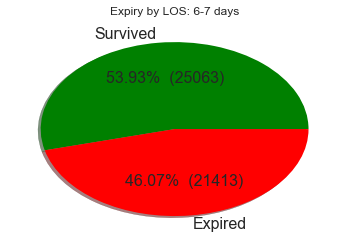

1 day


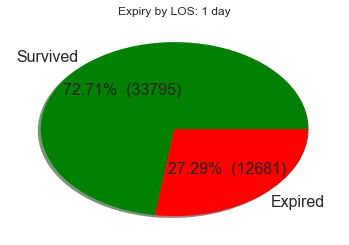

8-9 days


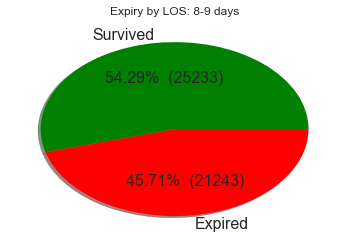

In [13]:
los_groups = dfmimic.groupby('los')
for group in los_groups.groups:
    print group
    ax = los_groups.get_group(group)['expire_flag'].value_counts().plot(labels = ['Survived', 'Expired'], 
        autopct=make_autopct(los_groups['expire_flag'].value_counts()), 
        shadow = True, fontsize = 16,
        kind = 'pie', colors = ['g', 'r'],
        title = 'Expiry by LOS: ' + group)
    ax.set_ylabel('')
    plt.savefig(group+'.png')
    plt.show(ax)

Self Pay


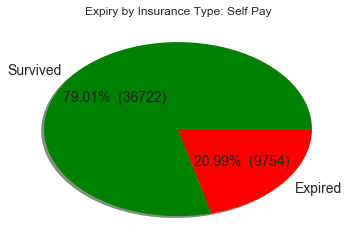

Medicaid


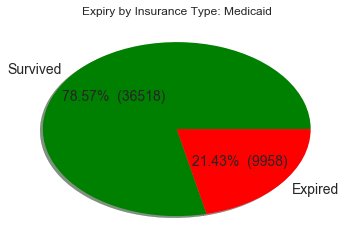

Medicare


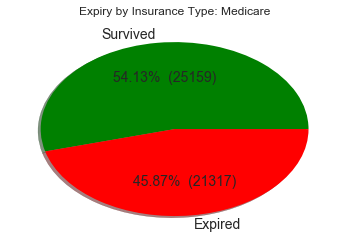

Private


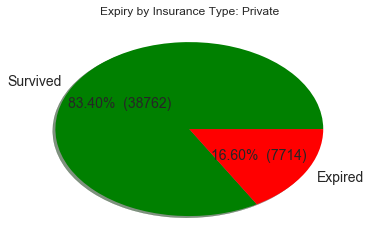

Government


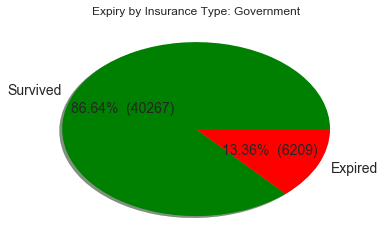

In [14]:
insurance_groups = dfmimic.groupby('insurance')
for group in insurance_groups.groups:
    print group
    ax = insurance_groups.get_group(group)['expire_flag'].value_counts().plot(labels = ['Survived', 'Expired'], 
        autopct= make_autopct(insurance_groups['expire_flag'].value_counts()),
        shadow = True, fontsize = 14,
        kind = 'pie', colors = ['g', 'r'],
        title = 'Expiry by Insurance Type: ' + group)
    ax.set_ylabel('')
    plt.savefig(group+'.png')
    plt.show(ax)

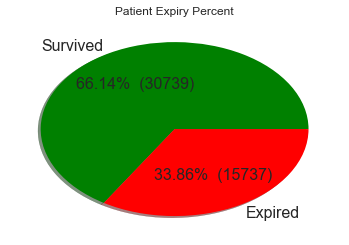

In [15]:
ax = dfmimic['expire_flag'].value_counts().plot(labels = ['Survived', 'Expired'], 
        autopct=make_autopct(dfmimic['expire_flag'].value_counts()), 
        shadow = True, fontsize = 16,
        kind = 'pie', colors = ['g', 'r'],
        title = 'Patient Expiry Percent')
ax.set_ylabel('')
plt.savefig('PatientExpiryPercent.png')
plt.show(ax)

In [73]:
#Compare different insurance type mortality rates
df_groupby_insurance = dfmimic.groupby('insurance')
print df_groupby_insurance['expire_flag'].value_counts()

insurance   expire_flag
Government  0               1297
            1                200
Medicaid    0               3436
            1                937
Medicare    1              11300
            0               9574
Private     0              15984
            1               3181
Self Pay    0                448
            1                119
Name: expire_flag, dtype: int64


### Part 2: Building the Benchmark Model
First we will start by building a benchmark model using only patient age and length of stay.  We will use only these two features as higher patient age and length of stay are consistently shown to have higher mortality rates.

In [16]:
#Select raw features
benchmark_features_raw = dfmimic[['age', 'los']]
#Select target (patient death)
expiry = dfmimic['expire_flag']

#Use one hot encoding to convert age and LOS groups to dummy variables
benchmark_features = pd.get_dummies(benchmark_features_raw)
print list(benchmark_features.columns)


['age_45-64 years', 'age_65-74 years', 'age_75-84 years', 'age_85 years and over', 'age_Under 45 years', 'los_1 day', 'los_10 or more days', 'los_2-3 days', 'los_4-5 days', 'los_6-7 days', 'los_8-9 days']


Use sklearn to split the data into test and train data.

In [17]:
from sklearn.model_selection import train_test_split

bench_train, bench_test, exp_train, exp_test = train_test_split(benchmark_features, expiry, random_state=42)

#Check for correct splitting
print "Training set has {} samples.".format(bench_train.shape[0])
print "Testing set has {} samples.".format(bench_test.shape[0])

Training set has 34857 samples.
Testing set has 11619 samples.


Create a training and predicting function to test different machine learning algorithms

In [18]:
def train_results(learner, X_train, y_train, X_test, y_test):
    '''
    inputs:
        -learner: type of learning algorithm to be compared
        -X_train: features training set
        -y_train: expiry training set
        -X_test: features test set
        -y_test: expiry training set
    '''
    
    results = {}
    
    #Fit the learner to the training data
    learner = learner.fit(X_train, y_train)
        
    #Get the predictions on the test set,
    predictions_test = learner.predict(X_test)
        
    #Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
        
    #Compute AUC score on the test set
    results['auc_test'] = roc_auc_score(y_test, predictions_test)
        
    # Return the results
    return results

Create models using features that are included in each ICU admission (gender, insurance).  Add these features to age and LOS.

In [61]:
def classifier_for_features(df, features, trials, verbose = True):
    '''
    df - The Pandas DataFrame with the data for training and testing
    features - A list of column features the classifier will use for training
    trials - An integer for the number of random trials the best classifier function will run
    verbose - Boolean whether to print dictionary and features
    '''
    
    #Preprocess feature data
    input_features_raw = df[features]
    input_features = pd.get_dummies(input_features_raw)
    
    #Get target variable
    expiry = df['expire_flag']
    
    #Assign dictionary name to features
    features_key = ' '.join(features)
    if df.name not in best_classifiers:
        best_classifiers[df.name] = {features_key: []}
    else:
        if features_key not in best_classifiers[df.name]:
            best_classifiers[df.name][features_key] = []
    
    #Add features to list for future data collection
    if features not in previous_features:
        previous_features.append(features)
        
    
    #Run best_classifier function
    best_classifiers[df.name][features_key] = \
    best_classifiers[df.name][features_key] + best_classifier(input_features, expiry, trials, clf_name_list)
    
    #Print data
    if verbose:
        print best_classifiers
        print previous_features
    
    

Evaluate classifiers:

In [23]:
#Import useful modules

import mimic_visuals as vs
from time import time

#Set up results dictionary for classifiers
clf_A = GaussianNB()
clf_B = tree.DecisionTreeClassifier(random_state=42)
clf_C = RandomForestClassifier(random_state =42)
clf_D = AdaBoostClassifier(random_state = 42)
#clf_E = SVC(random_state = 42)

clf_name_list = []
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    clf_name_list.append(clf_name)

best_classifiers = {} #Dictionary to store best classifiers and AUC scores
previous_features = []  #List to store features that have been analyzed
    
def best_classifier(features, expiry, trials, classifiers):
    '''
        -features: A dataframe containing the features for training
        -expiry: Target variable, binary patient death or survival
        -trials:  An integer denoting the number of random iterations
        -classifiers:  A list of supervised learning classifiers
    '''
    
    #Run through multiple times using random states
    results = {}
    for clf_name in classifiers:
        results[clf_name] = {}
    for trial in range(trials):
        state = random.randint(0,429496729)
        #print "Trial {}: Random State is {}".format(trial+1, state)
    
        #Create test and train samples
        X_train, X_test, y_train, y_test = train_test_split(features, expiry,
                                                                   random_state=random.randint(0,429496729))

        #  Initialize the models
        clf_A = GaussianNB()
        clf_B = tree.DecisionTreeClassifier(random_state=state)
        clf_C = RandomForestClassifier(random_state =state)
        clf_D = AdaBoostClassifier(random_state = state)
        #clf_E = SVC(random_state = state)       

        # Collect results on the learners
        for clf in [clf_A, clf_B, clf_C, clf_D]:
            clf_name = clf.__class__.__name__
            results[clf_name][trial] = \
            train_results(clf, X_train, y_train, X_test, y_test)

    #Find average AUC scores
    average_scores = {'accuracy': {}, 'auc': {}}
    #print results
    for clf in results:
        auc_scores = 0
        accuracy_scores = 0
        for trial in results[clf]:
            auc_scores+= results[clf][trial]['auc_test']
            accuracy_scores += results[clf][trial]['acc_test']
        average_scores['auc'][clf] = auc_scores/trials
        average_scores['accuracy'][clf] = accuracy_scores/trials   

    # Print final AUC scores
    #for clf in results:
    #    print "{} has an average AUC test score of {:.6f}".format(clf, average_scores['auc'][clf])
    #    print "{} has an average accuracy test score of {:.6f}".format(clf, average_scores['accuracy'][clf])
    #Print classifier with max AUC score
    max_auc_clf = max(average_scores['auc'].iterkeys(), key=(lambda key: average_scores['auc'][key]))
    print "{} has highest AUC test score of {:.6f}".format(max_auc_clf, average_scores['auc'][max_auc_clf])
    max_accuracy_clf = max(average_scores['accuracy'].iterkeys(), key=(lambda key: average_scores['accuracy'][key]))
    print "{} has highest accuracy score of {:.6f}".format(max_accuracy_clf, average_scores['accuracy'][max_accuracy_clf])
    #Return highest scores to be stored in dictionary
    return [max_auc_clf, average_scores['auc'][max_auc_clf]]
      
classifier_for_features(dfmimic, ['age', 'los'], 10)

GaussianNB has highest AUC test score of 0.701003
DecisionTreeClassifier has highest accuracy score of 0.735459
{'dfmimic': {'age los': ['GaussianNB', 0.70100269329742371]}}
[['age', 'los']]


From the benchmark model testing, we find that the GaussianNB has the highest AUC score with 0.6980.  With this as the chosen classification model, we can see whether we can improve this score. 

### Part 3: Building a model including gender and type of insurance


Create a function that will allow for quicker comparisons among different groups of features

In [24]:
#Select features
features_in_all_admissions = ['age', 'los', 'gender', 'insurance']
#Find best classifier for features included in all ICU admissions
classifier_for_features(dfmimic, features_in_all_admissions, 10)

GaussianNB has highest AUC test score of 0.712217
AdaBoostClassifier has highest accuracy score of 0.733807
{'dfmimic': {'age los': ['GaussianNB', 0.70100269329742371], 'age los gender insurance': ['GaussianNB', 0.71221686930113193]}}
[['age', 'los'], ['age', 'los', 'gender', 'insurance']]


We can see that adding 'gender' and 'insurance' features has improved the AUC score of the model from 0.6990 to 0.7119.  Let us further look into this to see whether adding one feature or the other changes the AUC score.

In [25]:
#Select benchmark features plus gender
benchmark_features_gender = ['age', 'los', 'gender']
#Find best classifier for features included in all ICU admissions
classifier_for_features(dfmimic, benchmark_features_gender, 10)

GaussianNB has highest AUC test score of 0.696970
AdaBoostClassifier has highest accuracy score of 0.732507
{'dfmimic': {'age los gender': ['GaussianNB', 0.6969701173886873], 'age los': ['GaussianNB', 0.70100269329742371], 'age los gender insurance': ['GaussianNB', 0.71221686930113193]}}
[['age', 'los'], ['age', 'los', 'gender', 'insurance'], ['age', 'los', 'gender']]


Best AUC score for 'gender' is GaussianNB classifier with AUC score of 0.6964

In [26]:
#Select benchmark features plus insurance
benchmark_features_insurance = ['age', 'los', 'insurance']
#Find best classifier for features included in all ICU admissions
classifier_for_features(dfmimic, benchmark_features_insurance, 10)

GaussianNB has highest AUC test score of 0.713156
AdaBoostClassifier has highest accuracy score of 0.733660
{'dfmimic': {'age los gender': ['GaussianNB', 0.6969701173886873], 'age los': ['GaussianNB', 0.70100269329742371], 'age los insurance': ['GaussianNB', 0.7131560907891602], 'age los gender insurance': ['GaussianNB', 0.71221686930113193]}}
[['age', 'los'], ['age', 'los', 'gender', 'insurance'], ['age', 'los', 'gender'], ['age', 'los', 'insurance']]


Best AUC score for 'insurance' is GaussianNB with 0.7128.  This is slightly better than both 'insurance' and 'gender' features added.  

Of interest will be seeing how using only patient intake features affect the predictability of patient mortality.  As LOS cannot be predicted when a patient enters the ICU, it would be of use to determine how the AUC scores are affected when the 'los' feature is removed.

In [27]:
no_los_all_admissions = ['age', 'gender', 'insurance']
no_los_features_insurance = ['age', 'insurance']
no_los_features_gender = ['age', 'gender']
classifier_for_features(dfmimic, no_los_all_admissions, 10)
classifier_for_features(dfmimic, no_los_features_insurance, 10)
classifier_for_features(dfmimic, no_los_features_gender, 10)

GaussianNB has highest AUC test score of 0.708659
DecisionTreeClassifier has highest accuracy score of 0.723487
{'dfmimic': {'age los gender': ['GaussianNB', 0.6969701173886873], 'age gender insurance': ['GaussianNB', 0.70865860810872905], 'age los': ['GaussianNB', 0.70100269329742371], 'age los insurance': ['GaussianNB', 0.7131560907891602], 'age los gender insurance': ['GaussianNB', 0.71221686930113193]}}
[['age', 'los'], ['age', 'los', 'gender', 'insurance'], ['age', 'los', 'gender'], ['age', 'los', 'insurance'], ['age', 'gender', 'insurance']]
GaussianNB has highest AUC test score of 0.709103
DecisionTreeClassifier has highest accuracy score of 0.726930
{'dfmimic': {'age los gender insurance': ['GaussianNB', 0.71221686930113193], 'age los gender': ['GaussianNB', 0.6969701173886873], 'age gender insurance': ['GaussianNB', 0.70865860810872905], 'age los insurance': ['GaussianNB', 0.7131560907891602], 'age insurance': ['GaussianNB', 0.70910304380943623], 'age los': ['GaussianNB', 0.70

### Part 4: Adding optional features to the model

Let us now look at the data with the optional features ('ethnicity', 'marital_status', 'religion', and 'language' added.  For these optional features we will be using the cleaned groups dataframe with rows containing 'NaN', 'UNKOWN', and 'UNABLE TO OBTAIN' values removed.

First let's create a function to allow us to compare how classifiers using the baseline features with the cleaned up DataFrame compare to classifiers using the optional features

In [28]:
def baseline_features(df, previous_features, trials):
    '''
        -df: The cleaned up DataFrame
        -previous_features: A list containing lists of feature names
        -trials: Number of randomized trials to run to find average AUC score
    '''
    
    for i in range(0,4): #Baseline features stored in indices 0-3
        classifier_for_features(df, previous_features[i], trials)

For ethnicity we will only look at the four ethnicities (white, black, hispanic, asian) contained within this study: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2569791/.  This will help reduce the amount of features in the model without removing too many data points.

In [29]:
#Ethnicity
#Clean up ethnicity DataFrame
df_ethnicity = dfmimic[['age', 'gender', 'los', 'insurance', 'ethnicity', 'expire_flag', 'subject_id']]
jnma_ethnicity = ['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO', 'ASIAN']
df_ethnicity = df_ethnicity[df_ethnicity['ethnicity'].isin(jnma_ethnicity)]
#Name df_ethnicity
df_ethnicity.name = 'df_ethnicity'

#Get baseline features data
baseline_features(df_ethnicity, previous_features, 10)    

#Use 'ethnicity' with 'age', 'los', 'gender', and 'insurance'
all_features_ethnicity = ['age', 'los', 'insurance', 'gender', 'ethnicity']

classifier_for_features(df_ethnicity, all_features_ethnicity, 10)

GaussianNB has highest AUC test score of 0.696402
DecisionTreeClassifier has highest accuracy score of 0.732616
{'df_ethnicity': {'age los': ['GaussianNB', 0.69640228469250576]}, 'dfmimic': {'age gender': ['GaussianNB', 0.6973423338081266], 'age los gender insurance': ['GaussianNB', 0.71221686930113193], 'age los gender': ['GaussianNB', 0.6969701173886873], 'age gender insurance': ['GaussianNB', 0.70865860810872905], 'age los insurance': ['GaussianNB', 0.7131560907891602], 'age insurance': ['GaussianNB', 0.70910304380943623], 'age los': ['GaussianNB', 0.70100269329742371]}}
[['age', 'los'], ['age', 'los', 'gender', 'insurance'], ['age', 'los', 'gender'], ['age', 'los', 'insurance'], ['age', 'gender', 'insurance'], ['age', 'insurance'], ['age', 'gender']]
GaussianNB has highest AUC test score of 0.713496
RandomForestClassifier has highest accuracy score of 0.733713
{'df_ethnicity': {'age los': ['GaussianNB', 0.69640228469250576], 'age los gender insurance': ['GaussianNB', 0.713496334731

Best AUC score for 'ethnicity' is GaussianNB with 0.7025  

In [30]:
#Marital Status
#Clean up marital status DataFrame
df_marital_status = dfmimic[['age', 'gender', 'los', 'insurance', 'marital_status', 'expire_flag', 'subject_id']]
df_marital_status = df_marital_status.dropna()
df_marital_status = df_marital_status[df_marital_status.marital_status != 'UNKNOWN (DEFAULT)']
#Name df_marital_status
df_marital_status.name = 'df_marital_status'

#Get baseline features data
baseline_features(df_marital_status, previous_features, 10)   

#Use 'marital_status' with 'age', 'los', 'gender', and 'insurance'
all_features_marital_status = ['age', 'los', 'insurance', 'gender', 'marital_status']

classifier_for_features(df_marital_status, all_features_marital_status, 10)

DecisionTreeClassifier has highest AUC test score of 0.658615
DecisionTreeClassifier has highest accuracy score of 0.684115
{'df_ethnicity': {'age los gender': ['GaussianNB', 0.69908709064325014], 'age los insurance gender ethnicity': ['GaussianNB', 0.70438695270116281], 'age los': ['GaussianNB', 0.69640228469250576], 'age los insurance': ['GaussianNB', 0.71256148184187174], 'age los gender insurance': ['GaussianNB', 0.71349633473127261]}, 'df_marital_status': {'age los': ['DecisionTreeClassifier', 0.65861540080944692]}, 'dfmimic': {'age gender': ['GaussianNB', 0.6973423338081266], 'age los gender insurance': ['GaussianNB', 0.71221686930113193], 'age los gender': ['GaussianNB', 0.6969701173886873], 'age gender insurance': ['GaussianNB', 0.70865860810872905], 'age los insurance': ['GaussianNB', 0.7131560907891602], 'age insurance': ['GaussianNB', 0.70910304380943623], 'age los': ['GaussianNB', 0.70100269329742371]}}
[['age', 'los'], ['age', 'los', 'gender', 'insurance'], ['age', 'los', 

Best AUC score for 'marital_status' is AdaBoostClassifier with 0.6585

In [31]:
#Language
#Clean up language DataFrame
df_language = dfmimic[['age', 'gender', 'los', 'insurance', 'language', 'expire_flag', 'subject_id']]
df_language = df_language.dropna()
#Adjust language for to use only top 5 spoken languages
print df_language['language'].value_counts()
top_5 = ['ENGL', 'SPAN', 'RUSS', 'PTUN', 'CANT']
df_language_5 = df_language[df_language['language'].isin(top_5)]
#Name df_language
df_language.name = 'df_language'

#Get baseline features data
baseline_features(df_language, previous_features, 10)   

#Use 'language' with 'age', 'los', 'gender', and 'insurance'
all_features_language = ['age', 'los', 'insurance', 'gender', 'language']

classifier_for_features(df_language, all_features_language, 10)

ENGL    21733
SPAN      800
RUSS      531
PTUN      522
CANT      320
PORT      274
CAPE      201
MAND      135
HAIT      106
ITAL       80
VIET       69
GREE       55
ARAB       28
PERS       24
POLI       23
HIND       23
CAMB       22
AMER       22
KORE       20
ALBA       15
FREN       13
THAI        9
*ARM        8
*BEN        7
LAOT        6
ETHI        6
SOMA        6
*URD        4
*GUJ        4
*CDI        4
        ...  
*HUN        2
** T        1
*YOR        1
*TAM        1
*LIT        1
*DEA        1
BENG        1
*PER        1
*TOY        1
*MOR        1
*KHM        1
*CAN        1
*BOS        1
*PHI        1
*FIL        1
*FUL        1
*NEP        1
* BE        1
*SPA        1
*ROM        1
*ARA        1
GERM        1
**SH        1
*RUS        1
*CRE        1
SERB        1
*MAN        1
*PUN        1
* FU        1
*FAR        1
Name: language, dtype: int64
GaussianNB has highest AUC test score of 0.632986
AdaBoostClassifier has highest accuracy score of 0.714099
{'df_ethn

In [32]:
#Religion
#Clean up religion DataFrame
df_religion = dfmimic[['age', 'gender', 'los', 'insurance', 'religion', 'expire_flag', 'subject_id']]
df_religion = df_religion.dropna()
#Keep religions that have value counts >= 10
religion_counts = df_religion['religion'].value_counts()
df_religion = df_religion[df_religion['religion'].isin(religion_counts[religion_counts >= 10].index)]
df_religion = df_religion[df_religion.religion != 'UNOBTAINABLE']
#Name df_religion
df_religion.name = 'df_religion'

#Get baseline features data
baseline_features(df_religion, previous_features, 10)   

#Use 'religion' with 'age', 'los', 'gender', and 'insurance'
all_features_religion = ['age', 'los', 'insurance', 'gender', 'religion']

classifier_for_features(df_religion, all_features_religion, 10)

GaussianNB has highest AUC test score of 0.684952
AdaBoostClassifier has highest accuracy score of 0.717828
{'df_ethnicity': {'age los gender': ['GaussianNB', 0.69908709064325014], 'age los insurance gender ethnicity': ['GaussianNB', 0.70438695270116281], 'age los': ['GaussianNB', 0.69640228469250576], 'age los insurance': ['GaussianNB', 0.71256148184187174], 'age los gender insurance': ['GaussianNB', 0.71349633473127261]}, 'df_language': {'age los gender': ['GaussianNB', 0.62645583862640675], 'age los insurance gender language': ['AdaBoostClassifier', 0.61366645485398785], 'age los': ['GaussianNB', 0.63298609066635014], 'age los insurance': ['GaussianNB', 0.65371367549319925], 'age los gender insurance': ['GaussianNB', 0.65448845764362051]}, 'df_marital_status': {'age los gender': ['RandomForestClassifier', 0.65637624221518054], 'age los insurance gender marital_status': ['AdaBoostClassifier', 0.6566829630445109], 'age los': ['DecisionTreeClassifier', 0.65861540080944692], 'age los in

Best score is AdaBoostClassifier with AUC score of 0.6763

### Part 5: Merging optional features
#### 2 optional features

In [33]:
#Merge ethnicity and marital status
df_ems = df_ethnicity.merge(df_marital_status, how='inner',
                                           on = ['subject_id', 'age', 'gender', 'los', 'insurance', 'expire_flag'])
df_ems.name = 'df_ems'
print len(df_ethnicity.index)
print len(df_marital_status.index)
print len(df_ems.index)
print list(df_ems.columns)

#Get baseline features data
baseline_features(df_ems, previous_features, 10)   

#Find best classifier with 'age' 'los' 'insurance' 'ethnicity' 'marital_status and 'gender' features
ems_features = ['age', 'los', 'insurance', 'gender', 'ethnicity', 'marital_status']

classifier_for_features(df_ems, ems_features, 10)

38298
36412
30615
['age', 'gender', 'los', 'insurance', 'ethnicity', 'expire_flag', 'subject_id', 'marital_status']
DecisionTreeClassifier has highest AUC test score of 0.653127
DecisionTreeClassifier has highest accuracy score of 0.679083
{'df_ems': {'age los': ['DecisionTreeClassifier', 0.65312660327318739]}, 'df_language': {'age los gender': ['GaussianNB', 0.62645583862640675], 'age los insurance gender language': ['AdaBoostClassifier', 0.61366645485398785], 'age los': ['GaussianNB', 0.63298609066635014], 'age los insurance': ['GaussianNB', 0.65371367549319925], 'age los gender insurance': ['GaussianNB', 0.65448845764362051]}, 'df_marital_status': {'age los gender': ['RandomForestClassifier', 0.65637624221518054], 'age los insurance gender marital_status': ['AdaBoostClassifier', 0.6566829630445109], 'age los': ['DecisionTreeClassifier', 0.65861540080944692], 'age los insurance': ['GaussianNB', 0.66665759897806343], 'age los gender insurance': ['GaussianNB', 0.66419883489683451]}, 'd

In [34]:
#Merge ethnicity and religion
df_er = df_ethnicity.merge(df_religion, how='inner',
                                           on = ['age', 'gender', 'los', 'insurance', 'expire_flag', 'subject_id'])
df_er.name = 'df_er'
print len(df_er.index)

#Get baseline features data
baseline_features(df_er, previous_features, 10)   

#Find best classifier with 'age' 'los' 'insurance' 'ethnicity' 'religion' and 'gender' features
er_features = ['age', 'los', 'insurance', 'gender', 'ethnicity', 'religion']

classifier_for_features(df_er, er_features, 10)

32956
GaussianNB has highest AUC test score of 0.684979
AdaBoostClassifier has highest accuracy score of 0.716604
{'df_er': {'age los': ['GaussianNB', 0.68497867822542069]}, 'df_ems': {'age los gender': ['GaussianNB', 0.65322909203089963], 'age los': ['DecisionTreeClassifier', 0.65312660327318739], 'age los insurance': ['DecisionTreeClassifier', 0.6628411499760416], 'age los gender insurance': ['GaussianNB', 0.6630122512431359], 'age los insurance gender ethnicity marital_status': ['GaussianNB', 0.6487685799353512]}, 'df_language': {'age los gender': ['GaussianNB', 0.62645583862640675], 'age los insurance gender language': ['AdaBoostClassifier', 0.61366645485398785], 'age los': ['GaussianNB', 0.63298609066635014], 'age los insurance': ['GaussianNB', 0.65371367549319925], 'age los gender insurance': ['GaussianNB', 0.65448845764362051]}, 'df_marital_status': {'age los gender': ['RandomForestClassifier', 0.65637624221518054], 'age los insurance gender marital_status': ['AdaBoostClassifier

In [35]:
#Merge ethnicity and language
df_el = df_ethnicity.merge(df_language, how='inner',
                                           on = ['age', 'gender', 'los', 'insurance', 'expire_flag', 'subject_id'])
df_el.name = 'df_el'
print len(df_el.index)

#Get baseline features data
baseline_features(df_el, previous_features, 10)   

#Find best classifier with 'age' 'los' 'insurance' 'ethnicity' 'language' and 'gender' features
el_features = ['age', 'los', 'insurance', 'gender', 'ethnicity', 'language']

classifier_for_features(df_el, el_features, 10)

21358
GaussianNB has highest AUC test score of 0.634810
AdaBoostClassifier has highest accuracy score of 0.710000
{'df_er': {'age los gender': ['GaussianNB', 0.6873589271894186], 'age los': ['GaussianNB', 0.68497867822542069], 'age los insurance': ['GaussianNB', 0.69805806673071413], 'age los gender insurance': ['GaussianNB', 0.69470568737340854], 'age los insurance gender ethnicity religion': ['GaussianNB', 0.68593525231033881]}, 'df_ems': {'age los gender': ['GaussianNB', 0.65322909203089963], 'age los': ['DecisionTreeClassifier', 0.65312660327318739], 'age los insurance': ['DecisionTreeClassifier', 0.6628411499760416], 'age los gender insurance': ['GaussianNB', 0.6630122512431359], 'age los insurance gender ethnicity marital_status': ['GaussianNB', 0.6487685799353512]}, 'df_language': {'age los gender': ['GaussianNB', 0.62645583862640675], 'age los insurance gender language': ['AdaBoostClassifier', 0.61366645485398785], 'age los': ['GaussianNB', 0.63298609066635014], 'age los insura

In [36]:
#Merge marital_status and religion
df_msr = df_marital_status.merge(df_religion, how='inner',
                                           on = ['age', 'gender', 'los', 'insurance', 'expire_flag', 'subject_id'])
df_msr.name = 'df_msr'
print len(df_msr.index)

#Get baseline features data
baseline_features(df_msr, previous_features, 10)   

#Find best classifier with 'age' 'los' 'insurance' 'religion' 'marital_status' and 'gender' features
msr_features = ['age', 'los', 'insurance', 'gender', 'marital_status', 'religion']

classifier_for_features(df_msr, msr_features, 10)

32489
GaussianNB has highest AUC test score of 0.642478
AdaBoostClassifier has highest accuracy score of 0.680401
{'df_er': {'age los gender': ['GaussianNB', 0.6873589271894186], 'age los': ['GaussianNB', 0.68497867822542069], 'age los insurance': ['GaussianNB', 0.69805806673071413], 'age los gender insurance': ['GaussianNB', 0.69470568737340854], 'age los insurance gender ethnicity religion': ['GaussianNB', 0.68593525231033881]}, 'df_ems': {'age los gender': ['GaussianNB', 0.65322909203089963], 'age los': ['DecisionTreeClassifier', 0.65312660327318739], 'age los insurance': ['DecisionTreeClassifier', 0.6628411499760416], 'age los gender insurance': ['GaussianNB', 0.6630122512431359], 'age los insurance gender ethnicity marital_status': ['GaussianNB', 0.6487685799353512]}, 'df_language': {'age los gender': ['GaussianNB', 0.62645583862640675], 'age los insurance gender language': ['AdaBoostClassifier', 0.61366645485398785], 'age los': ['GaussianNB', 0.63298609066635014], 'age los insura

In [37]:
#Merge marital_status and language
df_msl = df_marital_status.merge(df_language, how='inner',
                                           on = ['age', 'gender', 'los', 'insurance', 'expire_flag', 'subject_id'])
df_msl.name = 'df_msl'
print len(df_msl.index)



#Get baseline features data
baseline_features(df_msl, previous_features, 10)   

#Find best classifier with 'age' 'los' 'insurance' 'language' 'marital_status' and 'gender' features
msl_features = ['age', 'los', 'insurance', 'gender', 'marital_status', 'language']

classifier_for_features(df_msl, msl_features, 10)

23859
GaussianNB has highest AUC test score of 0.623402
AdaBoostClassifier has highest accuracy score of 0.716027
{'df_msl': {'age los': ['GaussianNB', 0.62340204190780102]}, 'df_er': {'age los gender': ['GaussianNB', 0.6873589271894186], 'age los': ['GaussianNB', 0.68497867822542069], 'age los insurance': ['GaussianNB', 0.69805806673071413], 'age los gender insurance': ['GaussianNB', 0.69470568737340854], 'age los insurance gender ethnicity religion': ['GaussianNB', 0.68593525231033881]}, 'df_ems': {'age los gender': ['GaussianNB', 0.65322909203089963], 'age los': ['DecisionTreeClassifier', 0.65312660327318739], 'age los insurance': ['DecisionTreeClassifier', 0.6628411499760416], 'age los gender insurance': ['GaussianNB', 0.6630122512431359], 'age los insurance gender ethnicity marital_status': ['GaussianNB', 0.6487685799353512]}, 'df_language': {'age los gender': ['GaussianNB', 0.62645583862640675], 'age los insurance gender language': ['AdaBoostClassifier', 0.61366645485398785], 'ag

In [38]:
#Merge religion and language
df_rl = df_religion.merge(df_language, how='inner',
                                           on = ['age', 'gender', 'los', 'insurance', 'expire_flag', 'subject_id'])
df_rl.name = 'df_rl'
print len(df_msr.index)

#Get baseline features data
baseline_features(df_rl, previous_features, 10)   

#Find best classifier with 'age' 'los' 'insurance' 'language' 'religion' and 'gender' features
rl_features = ['age', 'los', 'insurance', 'gender', 'religion', 'language']

classifier_for_features(df_rl, rl_features, 10)

32489
GaussianNB has highest AUC test score of 0.621870
AdaBoostClassifier has highest accuracy score of 0.714647
{'df_msl': {'age los gender': ['GaussianNB', 0.62534845046235776], 'age los': ['GaussianNB', 0.62340204190780102], 'age los insurance': ['GaussianNB', 0.65567733609812962], 'age los gender insurance': ['GaussianNB', 0.65818228012902691], 'age los insurance gender marital_status language': ['AdaBoostClassifier', 0.60802532575593926]}, 'df_er': {'age los gender': ['GaussianNB', 0.6873589271894186], 'age los': ['GaussianNB', 0.68497867822542069], 'age los insurance': ['GaussianNB', 0.69805806673071413], 'age los gender insurance': ['GaussianNB', 0.69470568737340854], 'age los insurance gender ethnicity religion': ['GaussianNB', 0.68593525231033881]}, 'df_ems': {'age los gender': ['GaussianNB', 0.65322909203089963], 'age los': ['DecisionTreeClassifier', 0.65312660327318739], 'age los insurance': ['DecisionTreeClassifier', 0.6628411499760416], 'age los gender insurance': ['Gauss

#### Merge 3 optional features

In [39]:
#Merge ethnicity, religion, and marital status
df_erms = df_ems.merge(df_er, how='inner',
                        on = ['age', 'gender', 'los', 'insurance', 'expire_flag', 'ethnicity', 'subject_id'])
df_erms.name = 'df_erms'
print len(df_erms.index)

#Get baseline features data
baseline_features(df_erms, previous_features, 10)   

#Find best classifier with 'age' 'los' 'insurance' 'ethnicity' 
# 'religion' 'marital_status' and 'gender' features
erms_features = ['age', 'los', 'insurance', 'gender', 'religion', 'ethnicity', 'marital_status']

classifier_for_features(df_erms, erms_features, 10)

27970
GaussianNB has highest AUC test score of 0.639816
AdaBoostClassifier has highest accuracy score of 0.675790
{'df_msl': {'age los gender': ['GaussianNB', 0.62534845046235776], 'age los': ['GaussianNB', 0.62340204190780102], 'age los insurance': ['GaussianNB', 0.65567733609812962], 'age los gender insurance': ['GaussianNB', 0.65818228012902691], 'age los insurance gender marital_status language': ['AdaBoostClassifier', 0.60802532575593926]}, 'df_er': {'age los gender': ['GaussianNB', 0.6873589271894186], 'age los': ['GaussianNB', 0.68497867822542069], 'age los insurance': ['GaussianNB', 0.69805806673071413], 'age los gender insurance': ['GaussianNB', 0.69470568737340854], 'age los insurance gender ethnicity religion': ['GaussianNB', 0.68593525231033881]}, 'df_ems': {'age los gender': ['GaussianNB', 0.65322909203089963], 'age los': ['DecisionTreeClassifier', 0.65312660327318739], 'age los insurance': ['DecisionTreeClassifier', 0.6628411499760416], 'age los gender insurance': ['Gauss

In [40]:
#Merge ethnicity, language, and marital status
df_elms = df_ems.merge(df_el, how='inner',
                        on = ['age', 'gender', 'los', 'insurance', 'expire_flag', 'ethnicity', 'subject_id'])
df_elms.name = 'df_elms'
print len(df_elms.index)

#Get baseline features data
baseline_features(df_elms, previous_features, 10)   

#Find best classifier with 'age' 'los' 'insurance' 'language' 
# 'ethnicity' 'marital_status' and 'gender' features
elms_features = ['age', 'los', 'insurance', 'gender', 'ethnicity', 'language', 'marital_status']

classifier_for_features(df_elms, elms_features, 10)

20818
GaussianNB has highest AUC test score of 0.632387
AdaBoostClassifier has highest accuracy score of 0.708742
{'df_msl': {'age los gender': ['GaussianNB', 0.62534845046235776], 'age los': ['GaussianNB', 0.62340204190780102], 'age los insurance': ['GaussianNB', 0.65567733609812962], 'age los gender insurance': ['GaussianNB', 0.65818228012902691], 'age los insurance gender marital_status language': ['AdaBoostClassifier', 0.60802532575593926]}, 'df_er': {'age los gender': ['GaussianNB', 0.6873589271894186], 'age los': ['GaussianNB', 0.68497867822542069], 'age los insurance': ['GaussianNB', 0.69805806673071413], 'age los gender insurance': ['GaussianNB', 0.69470568737340854], 'age los insurance gender ethnicity religion': ['GaussianNB', 0.68593525231033881]}, 'df_ems': {'age los gender': ['GaussianNB', 0.65322909203089963], 'age los': ['DecisionTreeClassifier', 0.65312660327318739], 'age los insurance': ['DecisionTreeClassifier', 0.6628411499760416], 'age los gender insurance': ['Gauss

In [41]:
#Merge religion, language, and marital status
df_msrl = df_msl.merge(df_msr, how='inner',
                        on = ['age', 'gender', 'los', 'insurance', 'expire_flag', 'marital_status', 'subject_id'])
df_msrl.name = 'df_msrl'
print len(df_msrl.index)

#Get baseline features data
baseline_features(df_msrl, previous_features, 10)   

#Find best classifier with 'age' 'los' 'insurance' 'language' 
# 'religion' 'marital_status' and 'gender' features
msrl_features = ['age', 'los', 'insurance', 'gender', 'religion', 'language', 'marital_status']

classifier_for_features(df_msrl, msrl_features, 10)

22176
GaussianNB has highest AUC test score of 0.624262
AdaBoostClassifier has highest accuracy score of 0.717118
{'df_msrl': {'age los': ['GaussianNB', 0.62426242243038321]}, 'df_msl': {'age los gender': ['GaussianNB', 0.62534845046235776], 'age los': ['GaussianNB', 0.62340204190780102], 'age los insurance': ['GaussianNB', 0.65567733609812962], 'age los gender insurance': ['GaussianNB', 0.65818228012902691], 'age los insurance gender marital_status language': ['AdaBoostClassifier', 0.60802532575593926]}, 'df_er': {'age los gender': ['GaussianNB', 0.6873589271894186], 'age los': ['GaussianNB', 0.68497867822542069], 'age los insurance': ['GaussianNB', 0.69805806673071413], 'age los gender insurance': ['GaussianNB', 0.69470568737340854], 'age los insurance gender ethnicity religion': ['GaussianNB', 0.68593525231033881]}, 'df_ems': {'age los gender': ['GaussianNB', 0.65322909203089963], 'age los': ['DecisionTreeClassifier', 0.65312660327318739], 'age los insurance': ['DecisionTreeClassifi

#### All features combined

In [42]:
#Merge religion, language, ethnicity, and marital status
df_emsrl = df_msrl.merge(df_elms, how='inner',
                        on = ['age', 'gender', 'los', 'insurance', 'expire_flag', 'marital_status', 'language', 'subject_id'])
df_emsrl.name = 'df_emsrl'

#Get AUC scores for all previous feature combinations with fully merged data frame
for feature_set in previous_features:
    classifier_for_features(df_emsrl, feature_set, 10)

#Get AUC score using all features
# 'age', 'los', 'insurance', 'gender', 'religion', 'language', 'marital_status', and 'ethnicity'
emsrl_features = ['age', 'los', 'insurance', 'gender', 'religion', 'language', 'marital_status']
classifier_for_features(df_emsrl, emsrl_features, 10)

GaussianNB has highest AUC test score of 0.622756
AdaBoostClassifier has highest accuracy score of 0.710744
{'df_msrl': {'age los gender': ['GaussianNB', 0.6225330228097401], 'age los': ['GaussianNB', 0.62426242243038321], 'age los insurance': ['GaussianNB', 0.64805510128999377], 'age los gender insurance': ['GaussianNB', 0.64857957426085799], 'age los insurance gender religion language marital_status': ['AdaBoostClassifier', 0.60387181268387113]}, 'df_msl': {'age los gender': ['GaussianNB', 0.62534845046235776], 'age los': ['GaussianNB', 0.62340204190780102], 'age los insurance': ['GaussianNB', 0.65567733609812962], 'age los gender insurance': ['GaussianNB', 0.65818228012902691], 'age los insurance gender marital_status language': ['AdaBoostClassifier', 0.60802532575593926]}, 'df_er': {'age los gender': ['GaussianNB', 0.6873589271894186], 'age los': ['GaussianNB', 0.68497867822542069], 'age los insurance': ['GaussianNB', 0.69805806673071413], 'age los gender insurance': ['GaussianNB',

### Part 6: Comparing Best Classifiers

In [43]:
#Find best classifier for each DataFrame
best_learners=[]

for df in best_classifiers:
    best_features = max(best_classifiers[df].iterkeys(), key=(lambda key: best_classifiers[df][key][1]))
    best_learner, learner_auc_score = best_classifiers[df][best_features][0], best_classifiers[df][best_features][1]
    print "{} : {} ".format(best_features, df)
    print "{} : AUC score {:.6f}".format(best_learner, learner_auc_score)
    best_learners.append([df, [df, best_features, best_learner, learner_auc_score]])

#Convert dictionary to DataFrame
df_best_classifiers = pd.DataFrame.from_dict(best_classifiers)
df_best_learners = pd.DataFrame.from_items(best_learners, orient='index',
                                           columns=['DataFrame', 'features', 'classifier', 'AUC_score'])

age los gender insurance : df_msrl 
GaussianNB : AUC score 0.648580
age los gender insurance : df_msl 
GaussianNB : AUC score 0.658182
age los insurance : df_er 
GaussianNB : AUC score 0.698058
age los gender insurance : df_ems 
GaussianNB : AUC score 0.663012
age los gender insurance : df_emsrl 
GaussianNB : AUC score 0.645952
age los gender insurance : df_language 
GaussianNB : AUC score 0.654488
age los insurance : df_marital_status 
GaussianNB : AUC score 0.666658
age los gender insurance : df_ethnicity 
GaussianNB : AUC score 0.713496
age los gender insurance : df_elms 
GaussianNB : AUC score 0.652259
age los gender insurance : df_erms 
GaussianNB : AUC score 0.655165
age los insurance : df_religion 
GaussianNB : AUC score 0.698253
age los insurance : df_rl 
GaussianNB : AUC score 0.652133
age los gender insurance : df_el 
GaussianNB : AUC score 0.652950
age los insurance : dfmimic 
GaussianNB : AUC score 0.713156
age los insurance : df_msr 
GaussianNB : AUC score 0.660598


In [44]:
#Output dictionary to CSV for Display
df_best_classifiers.to_csv('mimiciii3.csv')
df_best_learners.to_csv('best_learners3.csv')

Model Validation: After finding the model with the highest AUC score, we can run the testing/training algorithm several times to ensure the score is accurate.

In [71]:
def model_validation(df, features, trials):
    validation = {} #Libray to store results
    for i in range(trials):
        classifier_for_features(df, features, 10, verbose = False)
        validation['Trial '+ str(i)] = best_classifiers[df.name][' '.join(features)][i*2 + 3]
    return validation

best_classifier_validation = model_validation(df_ethnicity, ['age', 'los', 'gender', 'insurance'], 10)
baseline_validation = model_validation(dfmimic, ['age', 'los'], 10)

GaussianNB has highest AUC test score of 0.713600
AdaBoostClassifier has highest accuracy score of 0.733869
GaussianNB has highest AUC test score of 0.714964
AdaBoostClassifier has highest accuracy score of 0.734496
GaussianNB has highest AUC test score of 0.713727
AdaBoostClassifier has highest accuracy score of 0.734402
GaussianNB has highest AUC test score of 0.713200
AdaBoostClassifier has highest accuracy score of 0.733828
GaussianNB has highest AUC test score of 0.711485
AdaBoostClassifier has highest accuracy score of 0.734830
GaussianNB has highest AUC test score of 0.711466
AdaBoostClassifier has highest accuracy score of 0.732877
GaussianNB has highest AUC test score of 0.711413
AdaBoostClassifier has highest accuracy score of 0.732877
GaussianNB has highest AUC test score of 0.709109
AdaBoostClassifier has highest accuracy score of 0.733013
GaussianNB has highest AUC test score of 0.711554
AdaBoostClassifier has highest accuracy score of 0.733598
GaussianNB has highest AUC t

In [72]:
#Save validation dict to csv
df_best_validation = pd.DataFrame.from_dict(best_classifier_validation, orient = 'index')
df_baseline_validation = pd.DataFrame.from_dict(baseline_validation, orient = 'index')

df_best_validation.to_csv('best_validation.csv')
df_baseline_validation.to_csv('baseline_validation.csv')

In [76]:
print len(df_ethnicity.index)
print len(dfmimic.index)
print len(dfmimic.index)-len(df_ethnicity.index)

38298
46476
8178
